<a href="https://colab.research.google.com/github/davidrtorres/Deep_Learning/blob/main/image_segmentation__Machine_Learning_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Image Segmentation Using Traditional Machine Learning Models
Image Segmentation is a subfield of Atificial Intelligence and Computer Vision.  It is used to locate objects and boundaries in images.  It's used for partitioning an image into its regions based on some criteria, i.e.finding a cat in an image and isolating it.  Image segmentation is used to divide or partition the image into various parts called segments.  By dividing the image into segments we can use the important segments for processing the image.  An image is a collection of different pixels.  We group together the pixels that have similar attributes using image segmentation.  Image segmentation creates a pixel wide mask for each object in the image.  For example, all of the red pixels may belong to a dog and yellow pixels belong to a cat.  The point is that each pixel belongs to a certain class. 

Image Segmentation can be used for both Machine Learning and Deep Learning.  If you only have a few images or you don't have a lot of data it is best to use Machine Learning for image segmentation.  In this notebook I will show the process for image segmentation for both a single image and several images.  I followed the videos for image segmentation by Digital Sreeni.<br>
What is the goal?  We want to read an image and the corresponding mask/label image.  Next we want to create and train Random Forest and SVM models.  We want to use these models to segement future images that look similar to the images we used for training the models.<br>
The process will consist of the following steps:
1. Read the training images.<br>
2. Extract features<br>
2. Read labeled images and create another dataframe.<br>
3. Get the data ready for the model i.e., pre-processing, train/test split<br>
4. Create the Model and fit the model using the training set.<br>
5. Evaluate the accuracy of the model.<br>
6. Save the model for future use.
7. Make a prediction on new images.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import cv2
from keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Sequential

### Read the Images
This image is a microscope scan of a sandstone. 

In [2]:
img = cv2.imread('/content/drive/MyDrive/datasets/Sandstone_Versa0000.tif')

In [3]:
#this is an RGB image b/c there are 3 channels: Red, Green, Blue
img.size

3059712

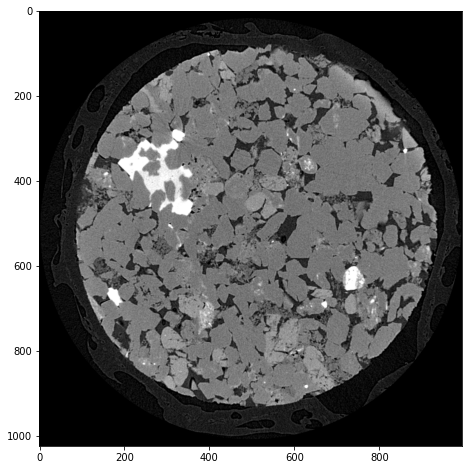

In [4]:
plt.figure(figsize=(8,8))
plt.imshow(img)

In [5]:
#color to gray scale
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  

In [6]:
img.size

1019904

## Feature Extraction
Which features do we need for the machine learning algorithm? We need the pixel values themselves.  Extract these features and put them into a Pandas dataframe.

In [7]:
#input image is a 2D, need to reshape to 1D 
img2 = img.reshape(-1)
#Save original image pixels into a data frame as feature #1.
df = pd.DataFrame()
df['Original_Image'] = img2
#df = df[df['Original_Image'] != 0]

In [8]:
df['Original_Image'].value_counts()

0      267036
122     15145
123     15037
124     14893
120     14881
        ...  
202        79
208        79
203        77
213        68
214        66
Name: Original_Image, Length: 256, dtype: int64

In [9]:
df.shape

(1019904, 1)

This is the label which will be used for predictions.

In [10]:
df.head()

,Original_Image
0,0
1,0
2,0
3,0
4,0


### Extracting Features
For image processing and Computer Vision, Gabor filters can be used for texture analysis, edge detection, and feature extraction.  Gabor filters are band pass filters meaning they allow a certain band of frequencies and reject other types.  Gabor is a good filter for machine learning.  The Gabor filter has several parameters which can be adjusted to generate lots responses from an image which will be placed in a dataframe as features.  We will be working with the theta, sigma, lamda and gamma paramters.  Gabor filters are used mainly with Random Forest and Support Vector algorithms.  The goal is to create a Pandas dataframe that has features consisting of the Gabor responses from an image.  In addition, we will be working with Canny, Roberts, Sobel, and Scharr filters.<br>
<br>
The process consists of extracting features from the training image by applying different filters.  A Gabor kernal will be created for each filter.  The kernal is then applied to the image which will generate responses.  We will then capture the responses are then appended to the dataframe as features.  We will use the date frame as the inputs for the models.  We will drop all pixels with a value of 0 because they represent areas that are not labeled because they do not contain any information.  

In [11]:
from skimage.filters import roberts,sobel, scharr, prewitt

In [12]:

#Generate Gabor features from image by applying Gabor filters
num = 1  #To count numbers up in order to give Gabor features a lable in the data frame
kernels = []  #Create empty list to hold all kernels that we will generate in a loop
for theta in range(2):   #Define number of thetas. Here only 2 theta values 0 and 1/4 . pi 
    theta = theta / 4. * np.pi
    for sigma in (1, 3):  #Sigma with values of 1 and 3
        for lamda in np.arange(0, np.pi, np.pi / 4):   #Range of wavelengths
            for gamma in (0.05, 0.5):   #Gamma values of 0.05 and 0.5
                           
                gabor_label = 'Gabor' + str(num)  #Label Gabor columns as Gabor1, Gabor2, etc.
                #print(gabor_label)
                #kernal size
                ksize=9
                #generate a Gabor kernal with each parameter 
                kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)    
                kernels.append(kernel)
                #apply kernal to image/filter the image and add values to a new column
                #when you get kernal apply it to image2
                #the filtered image is 2D 
                fimg = cv2.filter2D(img, cv2.CV_8UC3, kernel)
                #reshape filtered image/fimg to 1D
                filtered_img = fimg.reshape(-1)
                #add new column to dataframe
                df[gabor_label] = filtered_img  #Labels columns as Gabor1, Gabor2, etc.
                print(gabor_label, ': theta=', theta, ': sigma=', sigma, ': lamda=', lamda, ': gamma=', gamma)
                num += 1  #Increment for gabor column label
                

#Other filter responses
#Canny edge and other edge detection filters.  Applied filters to image, then add them as individual columns
edges = cv2.Canny(img, 100,200) #minimum and max value
edges1 = edges.reshape(-1)
df['Canny_Edge'] = edges1

edge_roberts = roberts(img) #minimum and max value
edge_roberts1 = edge_roberts.reshape(-1)
df['Roberts'] = edge_roberts1

edge_sobel = sobel(img) #minimum and max value
edge_sobel1 = edge_sobel.reshape(-1)
df['Sobel'] = edge_sobel1

edge_scharr = scharr(img) #minimum and max value
edge_scharr1 = edge_scharr.reshape(-1)
df['Scharr'] = edge_scharr1

Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.05
Gabor2 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.5
Gabor3 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.05
Gabor4 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor5 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.05
Gabor6 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.5
Gabor7 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.05
Gabor8 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.5
Gabor9 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.05
Gabor10 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.5
Gabor11 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.05
Gabor12 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor13 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.05
Gabor14 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.5
Gabor15 : theta= 0.0 : sigma= 3 : lamda= 2

In [13]:
labeled_img = cv2.imread("/content/drive/MyDrive/datasets/Sandstone_Versa0000_mask.tif")

In [14]:
labeled_img.size

3059712

In [15]:
labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_BGR2GRAY)  
labeled_img1 = labeled_img.reshape(-1)
df['Labels'] = labeled_img1

In [16]:
df.head()

,Original_Image,Gabor1,Gabor2,Gabor3,Gabor4,Gabor5,Gabor6,Gabor7,Gabor8,Gabor9,...,Gabor28,Gabor29,Gabor30,Gabor31,Gabor32,Canny_Edge,Roberts,Sobel,Scharr,Labels
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0.0,29
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0.0,29
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0.0,29
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0.0,29
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0.0,29


In [17]:
df['Labels'].value_counts()

29     522177
76     437060
150     45675
226     14992
Name: Labels, dtype: int64

In [18]:
df[df['Original_Image'] == 202 ]       

,Original_Image,Gabor1,Gabor2,Gabor3,Gabor4,Gabor5,Gabor6,Gabor7,Gabor8,Gabor9,...,Gabor28,Gabor29,Gabor30,Gabor31,Gabor32,Canny_Edge,Roberts,Sobel,Scharr,Labels
96022,202,0,0,255,255,223,140,90,55,0,...,255,30,16,74,47,0,0.058824,0.007904,0.010641,29
158642,202,0,0,255,255,255,192,132,93,0,...,255,103,64,154,91,0,0.066782,0.015960,0.018337,29
247582,202,0,0,255,255,255,212,164,104,0,...,255,59,29,106,61,0,0.033276,0.139012,0.145235,226
281204,202,0,0,255,255,255,198,152,80,0,...,255,91,47,146,76,255,0.207843,0.171344,0.171470,226
281205,202,0,0,255,255,255,195,141,84,0,...,255,110,66,180,112,255,0.174895,0.168314,0.173119,226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725479,202,0,0,255,255,255,181,129,69,0,...,255,80,43,173,110,255,0.093215,0.110940,0.111930,76
736432,202,0,0,255,255,255,184,130,80,0,...,255,44,12,118,70,0,0.067980,0.079363,0.084545,76
741411,202,0,0,255,255,255,180,123,81,0,...,255,82,40,172,99,0,0.089426,0.054621,0.052159,76
801378,202,0,0,255,255,255,201,136,88,0,...,255,69,40,77,39,255,0.089511,0.122905,0.128623,226


In [19]:
#want to use this as test image after training
original_img_data = df.drop(labels=['Labels'], axis=1)
#updated dataframe where Label doesn't = 0
#df_1 = df[df['Labels'] != 0]

In [20]:
df['Labels'].value_counts()

29     522177
76     437060
150     45675
226     14992
Name: Labels, dtype: int64

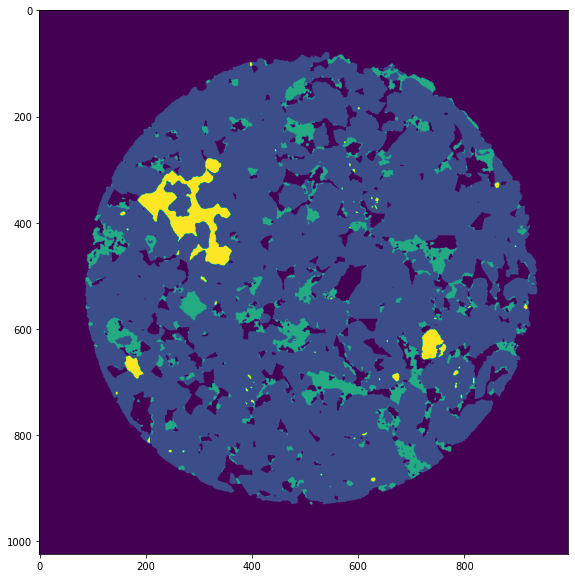

In [21]:
#labeled image will be used for model to make preduction. Every pixel has red, blue, yellow, green
plt.figure(figsize=(10,10))
plt.imshow(labeled_img)

In [22]:
#Dataframe with Gabor responses
#created a Gabor filter bank and generated response by applying each kernal of filter bank to the original image.
df.head()

,Original_Image,Gabor1,Gabor2,Gabor3,Gabor4,Gabor5,Gabor6,Gabor7,Gabor8,Gabor9,...,Gabor28,Gabor29,Gabor30,Gabor31,Gabor32,Canny_Edge,Roberts,Sobel,Scharr,Labels
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0.0,29
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0.0,29
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0.0,29
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0.0,29
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0.0,29


In [23]:
df_1 = df[df['Original_Image'] != 0]
#original_img_data = df_1.drop(labels=['Labels'], axis=1)

In [24]:
df_1.shape

(752868, 38)

In [25]:
df_1.head()

,Original_Image,Gabor1,Gabor2,Gabor3,Gabor4,Gabor5,Gabor6,Gabor7,Gabor8,Gabor9,...,Gabor28,Gabor29,Gabor30,Gabor31,Gabor32,Canny_Edge,Roberts,Sobel,Scharr,Labels
17411,14,0,0,24,13,0,0,0,0,0,...,57,19,16,0,0,0,0.035076,0.043182,0.045694,29
17412,19,0,0,57,36,23,18,11,11,0,...,74,0,0,2,1,0,0.023692,0.037665,0.040733,29
17413,15,0,0,69,34,38,17,27,11,0,...,95,4,3,18,16,0,0.031617,0.039411,0.040304,29
17414,8,0,0,24,9,0,0,0,0,0,...,94,5,4,0,0,0,0.002773,0.024588,0.025288,29
17415,5,0,0,7,6,0,0,0,0,0,...,82,0,0,0,0,0,0.021658,0.024510,0.024915,29


In [26]:
df_1['Original_Image'].value_counts()

122    15145
123    15037
124    14893
120    14881
121    14797
       ...  
202       79
208       79
203       77
213       68
214       66
Name: Original_Image, Length: 255, dtype: int64

In [27]:
df_1.shape

(752868, 38)

## Spliting Input Data into Training and Testing Datasets
The dependent variable is the label.  We're trying to predict something so the independent variables will affect the prediction. 

In [28]:
#dependent variable
y = df_1['Labels'].values
#independent variables
X = df_1.drop('Labels',axis=1)
print(X.shape), print(y.shape)

(752868, 37)
(752868,)


(None, None)

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [31]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(504421, 37)
(504421,)
(248447, 37)
(248447,)


## Build the Model 
### Random Forest Classifier
Train the Random Forest Classifier using the training set.

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [33]:
#create an instance of model
model = RandomForestClassifier(n_estimators=10,random_state=42)
#fit model to training dataset
model.fit(X_train, y_train)
#need to validate model. Is it doing a good job?
y_train_pred = model.predict(X_train) 
print("Train Accuracy: ", metrics.accuracy_score(y_train, y_train_pred)) 
#make a prediction
prediction = model.predict(X_test)
#how good was model at making prediction? Accuracy of prediction 
print('Test Accuracy: ',metrics.accuracy_score(y_test, prediction))

Train Accuracy:  0.9970679254035816
Test Accuracy:  0.9566507142368392


## Feature Ranking 
Which features contributed the most to teh model in making a prediction.  Gabor6 and Gabor24 were the 2 features which had the most impact on the model in making a prediction.  Canny_Edge didn't have a big impact on the model.  If we wanted to improve the accuracy of the model we would create a subset of the features that had the biggest impact and run the model again. 

In [34]:
importances = list(model.feature_importances_)
features_list = list(X.columns)
feature_imp = pd.Series(model.feature_importances_, index=features_list).sort_values(ascending=False)

In [35]:
print(round(feature_imp,4) * 100)

Gabor6            22.33
Gabor23           13.16
Gabor4            11.54
Original_Image     7.76
Gabor24            7.71
Gabor3             7.01
Gabor21            6.91
Gabor12            6.48
Gabor5             4.23
Gabor7             2.27
Roberts            1.82
Scharr             1.52
Sobel              1.47
Gabor8             1.14
Gabor29            1.06
Gabor31            0.90
Gabor32            0.71
Gabor30            0.71
Gabor11            0.49
Gabor22            0.37
Canny_Edge         0.23
Gabor28            0.10
Gabor27            0.05
Gabor20            0.01
Gabor13            0.00
Gabor14            0.00
Gabor16            0.00
Gabor15            0.00
Gabor19            0.00
Gabor1             0.00
Gabor17            0.00
Gabor26            0.00
Gabor25            0.00
Gabor9             0.00
Gabor2             0.00
Gabor10            0.00
Gabor18            0.00
dtype: float64


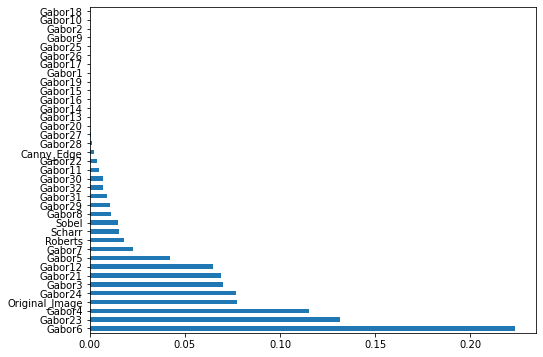

In [36]:
feature_imp.plot(kind='barh', figsize=(8,6));

### Support Vector Machine Model

In [37]:
from sklearn.svm import LinearSVC

model_svm = LinearSVC(max_iter=200)
model_svm.fit(X_train, y_train)
prediction_svm = model_svm.predict(X_test)
# print("Train Accuracy: ", metrics.accuracy_score(y_train, y_train_pred)) 
# #make a prediction

#how good was model at making prediction? Accuracy of prediction 
print('Test Accuracy: ',metrics.accuracy_score(y_test, prediction_svm))

Test Accuracy:  0.9419473771065862


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


The line represents is random line or chance line which means that if I randomly pick a pixel and randomly assign it to one of the four classes there is a 25% chance that I'll get it right.  The closer the curves get to the chance line the worse the model is performing.  You want the curves as close to the upper left hand corner as poosible.  The space between the curves and chance line is the area under the curve. 

In [38]:
from yellowbrick.classifier import ROCAUC

In [39]:
print('Classes in the image are: ', np.unique(y))

Classes in the image are:  [ 29  76 150 226]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


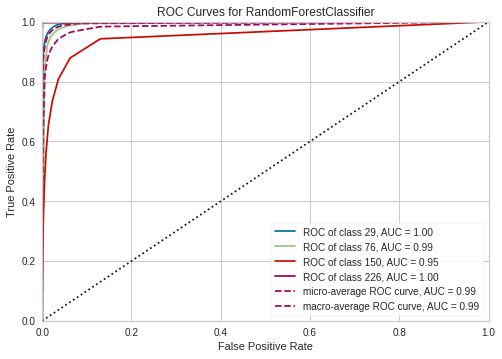

In [40]:
roc_auc = ROCAUC(model)
roc_auc.fit(X_train, y_train)
roc_auc.score(X_test, y_test)
roc_auc.show()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  "X does not have valid feature names, but"


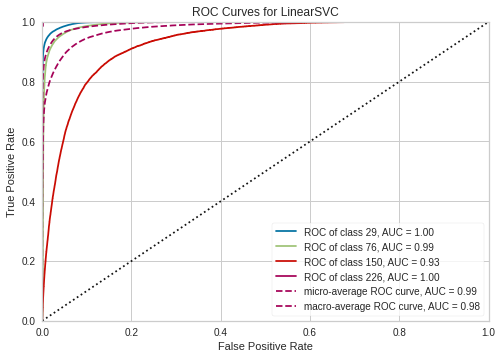

In [41]:
roc_auc1 = ROCAUC(model_svm)
roc_auc1.fit(X_train, y_train)
roc_auc1.score(X_test, y_test)
roc_auc1.show()

### Save the Model
Store the model for future use in the file sandstone_model.

In [42]:
import pickle

In [43]:
#using pickle to dump the model into a file sandstone_model
#saves the file sandstone_model in hard drive
filename = "/content/drive/MyDrive/datasets/sandstone_model"
pickle.dump(model, open(filename, 'wb')) #w is for write mode, b is for binary

### Load Saved Model and Make Predictions
Want to use saved model to segment images. 

In [44]:
#load model to segment images
#test model on future datasets
loaded_model = pickle.load(open(filename, 'rb')) #read binary mode
#make prediction. Predict on all pixels in X or can do X_test
#predict it onto original image
result = loaded_model.predict(original_img_data)
#convert column into original size 1024 x 96
segmented = result.reshape((img.shape)) 
segmented.shape

(1024, 996)

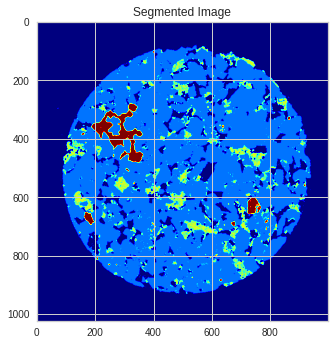

In [45]:
plt.title('Segmented Image')
plt.imshow(segmented, cmap='jet')
#save segmented image onto hard drive
plt.imsave('/content/drive/MyDrive/datasets/segmented_rock.jpg',segmented, cmap='jet')

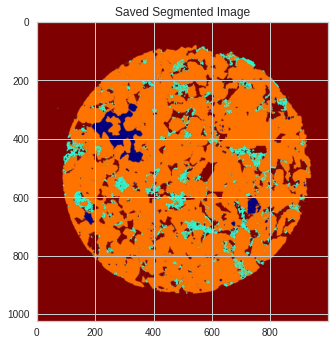

In [46]:
path='/content/drive/MyDrive/datasets/segmented_rock.jpg'
img2 = cv2.imread(path)
plt.title('Saved Segmented Image')
plt.imshow(img2, cmap = 'jet');

Comparing the original image to the segmented image.  The outer regions are in dark blue. The textured regions are in different colors and everything else is in light blue.

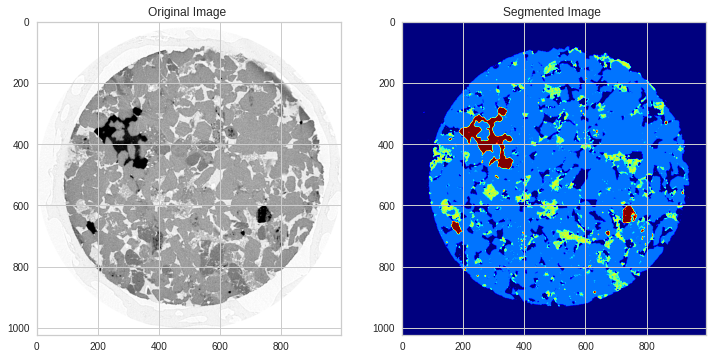

In [47]:
plt.figure(figsize=(12,12))
plt.subplot(121)
plt.title("Original Image ")
plt.imshow(img)
plt.subplot(122)
plt.imshow(segmented, cmap='jet')
plt.title("Segmented Image ");

### Segmenting Multiple Images Using the Saved Model

We are going to load the saved model and use it to segment multiple images.
To segment images we need to extract features exactly the same way we did during the above training process, i.e. Gabor_1 needs to mean the same thing.  the same set of features.  We can segment an image by taking the original images and creating a dateframe that has the exact same set of features.  Then we can make a prediction.
We'll be working with unknown data.

In [48]:
def feature_extraction(img):
  df = pd.DataFrame()
  #input image is a 2D, need to reshape to 1D 
  img2 = img.reshape(-1)
  #Save original image pixels into a data frame as feature #1.
  df['Original Image'] = img2
  num = 1  #To count numbers up in order to give Gabor features a lable in the data frame
  kernels = []  #Create empty list to hold all kernels that we will generate in a loop
  for theta in range(2):   #Define number of thetas. Here only 2 theta values 0 and 1/4 . pi 
      theta = theta / 4. * np.pi
      for sigma in (1, 3):  #Sigma with values of 1 and 3
          for lamda in np.arange(0, np.pi, np.pi / 4):   #Range of wavelengths
              for gamma in (0.05, 0.5):   #Gamma values of 0.05 and 0.5
                           
                  gabor_label = 'Gabor' + str(num)  #Label Gabor columns as Gabor1, Gabor2, etc.
#                 print(gabor_label)
                  #kernal size
                  ksize=9
                  #generate a Gabor kernal with each parameter 
                  kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)    
                  kernels.append(kernel)
                  #apply kernal to image/filter the image and add values to a new column
                  #when you get kernal apply it to image2
                  #the filtered image is 2D 
                  fimg = cv2.filter2D(img2, cv2.CV_8UC3, kernel)
                  #reshape filtered image/fimg to 1D
                  filtered_img = fimg.reshape(-1)
                  #add new column to dataframe
                  df[gabor_label] = filtered_img  #Labels columns as Gabor1, Gabor2, etc.
                  print(gabor_label, ': theta=', theta, ': sigma=', sigma, ': lamda=', lamda, ': gamma=', gamma)
                  num += 1  #Increment for gabor column label

   #canny edge. Edge detection filter.  Get a canny edge filter
  edges = cv2.Canny(img, 100,200) #minimum and max value
  edges1 = edges.reshape(-1)
  df['Canny_Edge'] = edges1

  edge_roberts = roberts(img) #minimum and max value
  edge_roberts1 = edge_roberts.reshape(-1)
  df['Roberts'] = edge_roberts1

  edge_sobel = sobel(img) #minimum and max value
  edge_sobel1 = edge_sobel.reshape(-1)
  df['Sobel'] = edge_sobel1

  edge_scharr = scharr(img) #minimum and max value
  edge_scharr1 = edge_scharr.reshape(-1)
  df['Scharr'] = edge_scharr1 

  return df            

In [49]:
import glob

In [50]:
#load the model
filename = "/content/drive/MyDrive/datasets/sandstone_model"
load_model = pickle.load(open(filename, 'rb')) #read binary mode

In [51]:
import tifffile
import os
import io

In [52]:
path = '/content/drive/MyDrive/datasets/Test_images/'

#path = '/content/drive/MyDrive/datasets/Test_images/*.tiff'
# for file in glob.glob(path):
#   img1 = cv2.imread(file)
#   img = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY) #convert to gray level
#    #feature extraction
#   X = feature_extraction(img)
#   result = load_model.predict(X)
#   #reshape to original image shape
#   segmented = result.reshape((img.shape))
#   name = file.split("e_")
#   tifffile.imwrite('/content/drive/MyDrive/datasets/Segmented/' + name[1], segmented) #/content/drive/MyDrive/datasets/

for image in os.listdir(path):
  print(image)
  img1 = cv2.imread(path + image)
  img = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

  #call the feature extraction column
  X = feature_extraction(img) #extracting features on my input image
  result = load_model.predict(X)
  segmented = result.reshape((img.shape))
  segmented = segmented.astype(np.int8)
  #io.imsave("/content/drive/MyDrive/datasets/Segmented_images/" + image, segmented)
  tifffile.imwrite('/content/drive/MyDrive/datasets/Segmented/' + image, segmented)

sandstone_0015.tiff
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.05
Gabor2 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.5
Gabor3 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.05
Gabor4 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor5 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.05
Gabor6 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.5
Gabor7 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.05
Gabor8 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.5
Gabor9 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.05
Gabor10 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.5
Gabor11 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.05
Gabor12 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor13 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.05
Gabor14 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.5
Gabor15 : theta= 0.0 :

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Original Image
Feature names seen at fit time, yet now missing:
- Original_Image

  warnings.warn(message, FutureWarning)


sandstone_0075.tiff
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.05
Gabor2 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.5
Gabor3 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.05
Gabor4 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor5 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.05
Gabor6 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.5
Gabor7 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.05
Gabor8 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.5
Gabor9 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.05
Gabor10 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.5
Gabor11 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.05
Gabor12 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor13 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.05
Gabor14 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.5
Gabor15 : theta= 0.0 :

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Original Image
Feature names seen at fit time, yet now missing:
- Original_Image

  warnings.warn(message, FutureWarning)


sandstone_0120.tiff
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.05
Gabor2 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.5
Gabor3 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.05
Gabor4 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor5 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.05
Gabor6 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.5
Gabor7 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.05
Gabor8 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.5
Gabor9 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.05
Gabor10 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.5
Gabor11 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.05
Gabor12 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor13 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.05
Gabor14 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.5
Gabor15 : theta= 0.0 :

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Original Image
Feature names seen at fit time, yet now missing:
- Original_Image

  warnings.warn(message, FutureWarning)


sandstone_0180.tiff
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.05
Gabor2 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.5
Gabor3 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.05
Gabor4 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor5 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.05
Gabor6 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.5
Gabor7 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.05
Gabor8 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.5
Gabor9 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.05
Gabor10 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.5
Gabor11 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.05
Gabor12 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor13 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.05
Gabor14 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.5
Gabor15 : theta= 0.0 :

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Original Image
Feature names seen at fit time, yet now missing:
- Original_Image

  warnings.warn(message, FutureWarning)


sandstone_0270.tiff
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.05
Gabor2 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.5
Gabor3 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.05
Gabor4 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor5 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.05
Gabor6 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.5
Gabor7 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.05
Gabor8 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.5
Gabor9 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.05
Gabor10 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.5
Gabor11 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.05
Gabor12 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor13 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.05
Gabor14 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.5
Gabor15 : theta= 0.0 :

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Original Image
Feature names seen at fit time, yet now missing:
- Original_Image

  warnings.warn(message, FutureWarning)


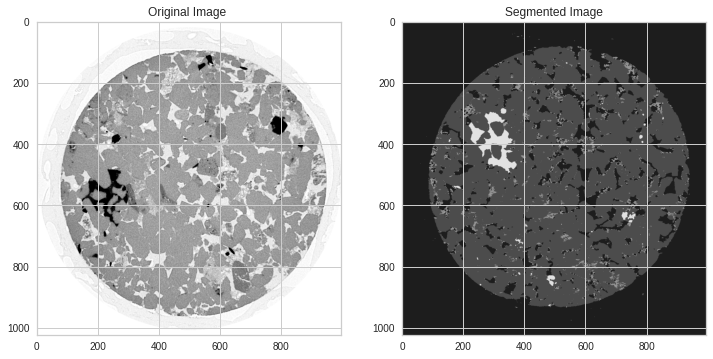

In [53]:
plt.figure(figsize=(12,12))
plt.subplot(121)
plt.title("Original Image ")
plt.imshow(img)
plt.subplot(122)
img3 = cv2.imread("/content/drive/MyDrive/datasets/Segmented/sandstone_0015.tiff") 
#cv.rectangle(img,(29,2496),(604,2992),(255,0,0),5)
plt.title("Segmented Image")
plt.imshow(img3);